# Predicting Focal Colours From Natural Imagess

In [172]:
from wcs_helper_functions import (
    readNamingData,
    readFociData,
    readChipData,
    readSpeakerData,
    readClabData
)
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
from scipy import stats
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage.color import lab2rgb, rgb2lab
from PIL import Image
import os
import glob
from tqdm import tqdm

np.random.seed(42)

In [173]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("akash2sharma/tiny-imagenet")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\user\.cache\kagglehub\datasets\akash2sharma\tiny-imagenet\versions\1


In [174]:
# Constants
IMAGE_PATH = path + "/tiny-imagenet-200/test/images"
MAX_IMAGES = 10000  # Limit for faster processing
PIXELS_PER_IMAGE = 100  # Number of pixels to sample per image
WCS_DATA_DIR = "WCS_data_core"

## Preprocess

In [175]:
# Load WCS Data
naming_data = readNamingData(f"{WCS_DATA_DIR}/term.txt")
foci_data = readFociData(f"{WCS_DATA_DIR}/foci-exp.txt")
cnum_dict, cname_dict = readChipData(f"{WCS_DATA_DIR}/chip.txt")
speaker_data = readSpeakerData(f"{WCS_DATA_DIR}/spkr-lsas.txt")
clab_data = readClabData(f"{WCS_DATA_DIR}/cnum-vhcm-lab-new.txt")

In [176]:
def count_basic_colour_terms(naming_data):
    language_term_counts = {}
    for lang_id in naming_data:
        all_terms = set()
        for speaker_id in naming_data[lang_id]:
            for chip_num in naming_data[lang_id][speaker_id]:
                all_terms.add(naming_data[lang_id][speaker_id][chip_num])
        language_term_counts[lang_id] = len(all_terms)
    return language_term_counts


def extract_focal_colours_lab(foci_data, cnum_dict, clab_data):
    focal_colours = defaultdict(lambda: defaultdict(list))

    for lang_id in foci_data:
        for speaker_id in foci_data[lang_id]:
            for term in foci_data[lang_id][speaker_id]:
                coords = foci_data[lang_id][speaker_id][term]
                for coord in coords:
                    coord_clean = coord.replace(':', '')
                    if coord_clean in cnum_dict:
                        chip_num = cnum_dict[coord_clean]
                        if chip_num in clab_data:
                            lab_tuple = clab_data[chip_num]
                            L, a, b = float(lab_tuple[0]), float(
                                lab_tuple[1]), float(lab_tuple[2])
                            focal_colours[lang_id][term].append((L, a, b))
    return focal_colours


def get_average_focal_colours(focal_colours):
    avg_focals = defaultdict(dict)
    for lang_id in focal_colours:
        for term in focal_colours[lang_id]:
            colours = focal_colours[lang_id][term]
            if colours:
                avg_focals[lang_id][term] = (
                    np.mean([c[0] for c in colours]),
                    np.mean([c[1] for c in colours]),
                    np.mean([c[2] for c in colours])
                )
    return avg_focals

In [177]:
language_term_counts = count_basic_colour_terms(naming_data)
focal_colours_lab = extract_focal_colours_lab(foci_data, cnum_dict, clab_data)
avg_focal_colours = get_average_focal_colours(focal_colours_lab)

In [178]:
def find_all_images(image_dir, max_images=10000):
    image_files = []
    extensions = ['*.jpg', '*.jpeg', '*.png', '*.JPEG', '*.JPG', '*.PNG']

    if not os.path.exists(image_dir):
        print(f"Directory not found: {image_dir}")
        return image_files

    for ext in extensions:
        found = glob.glob(os.path.join(image_dir, ext))
        image_files.extend(found)

        found_sub = glob.glob(os.path.join(image_dir, '*', ext))
        image_files.extend(found_sub)

    return image_files[:max_images]

In [179]:
def extract_colours_from_image(image_path, n_samples):
    try:
        img = Image.open(image_path).convert('RGB')
        img_array = np.array(img)
        pixels = img_array.reshape(-1, 3)

        # Normalize to 0-1 range for skimage
        pixels_norm = pixels.astype(np.float64) / 255.0

        # Convert to LAB space, shape becomes (N, 3) where columns are L, a, b
        lab_colours = rgb2lab(pixels_norm.reshape(-1, 1, 3)).reshape(-1, 3)

        L = lab_colours[:, 0]
        a = lab_colours[:, 1]
        b = lab_colours[:, 2]

        # Calculate Chroma (Saturation magnitude in LAB)
        chroma = np.sqrt(a**2 + b**2)

        mask = (L < 25) | (L > 80) | (chroma > 30)

        filtered_lab = lab_colours[mask]

        # If we filtered everything out, fall back to original
        if len(filtered_lab) < n_samples:
            filtered_lab = lab_colours

        n_pixels = len(filtered_lab)
        if n_pixels > 0:
            indices = np.random.choice(n_pixels, min(
                n_samples, n_pixels), replace=False)
            return filtered_lab[indices]
        else:
            return np.array([]).reshape(0, 3)

    except Exception as e:
        return np.array([]).reshape(0, 3)

In [180]:
def load_colours_from_images(image_files, pixels_per_image):
    all_colours = []

    print(f"Extracting colours from {len(image_files)} images...")
    for _, img_path in tqdm(enumerate(image_files), total=len(image_files)):
        colours = extract_colours_from_image(img_path, pixels_per_image)
        if len(colours) > 0:
            all_colours.append(colours)

    all_colours = np.vstack(
        all_colours) if all_colours else np.array([]).reshape(0, 3)
    return all_colours

In [181]:
image_files = find_all_images(IMAGE_PATH, max_images=MAX_IMAGES)
natural_colours = load_colours_from_images(
    image_files, pixels_per_image=PIXELS_PER_IMAGE)

Extracting colours from 10000 images...


100%|██████████| 10000/10000 [00:16<00:00, 623.34it/s]


In [182]:
print(f"Total colour samples: {len(natural_colours)}")
print(
    f"L range: [{natural_colours[:, 0].min():.1f}, {natural_colours[:, 0].max():.1f}]")
print(
    f"a range: [{natural_colours[:, 1].min():.1f}, {natural_colours[:, 1].max():.1f}]")
print(f"b range: [{natural_colours[:, 2].min():.1f}, {natural_colours[:,2].max():.1f}]")

Total colour samples: 1000000
L range: [0.0, 100.0]
a range: [-85.9, 96.7]
b range: [-105.9, 94.3]


## KMeans

In [183]:
def optimal_kmeans_partition(colours, n_clusters, n_init=20):
    """K-means clustering for optimal colour space partition."""
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init,
                    max_iter=500, random_state=42)
    kmeans.fit(colours)
    return kmeans.cluster_centers_, kmeans.labels_, kmeans.inertia_

In [184]:
predicted_focals_kmeans = {}

silhouette_inertia = {}

for n in range(2, 12):
    centers_km, labels_km, inertia = optimal_kmeans_partition(
        natural_colours, n)
    predicted_focals_kmeans[n] = centers_km

    sample_size = min(5000, len(natural_colours))

    silhouette_km = silhouette_score(
        natural_colours, labels_km, sample_size=sample_size)  # How well separated are the clusters?

    silhouette_inertia[n] = (silhouette_km, inertia)
    print(f"N={n:2d}: Silhouette={silhouette_km:.3f}, Inertia={inertia:.0f}")

N= 2: Silhouette=0.556, Inertia=733730938
N= 3: Silhouette=0.552, Inertia=477510966
N= 4: Silhouette=0.535, Inertia=381495237
N= 5: Silhouette=0.565, Inertia=301061171
N= 6: Silhouette=0.543, Inertia=266777784
N= 7: Silhouette=0.389, Inertia=239379538
N= 8: Silhouette=0.385, Inertia=221551231
N= 9: Silhouette=0.393, Inertia=204653904
N=10: Silhouette=0.311, Inertia=191833013
N=11: Silhouette=0.329, Inertia=179708051


In [185]:
def find_best_matching(predicted, actual):
    """Find average minimum distance from each actual focal to nearest predicted.
    
    For every colour term in a language, is there a cluster center (predicted focal) nearby?
    """
    if len(predicted) == 0 or len(actual) == 0:
        return np.inf, []
    distances = cdist(actual, predicted, metric='euclidean')
    min_distances = distances.min(axis=1)
    return min_distances.mean(), min_distances


def get_languages_by_n_terms(language_term_counts, n):
    return [l for l, c in language_term_counts.items() if c == n]


def evaluate_prediction(predicted_focals, avg_focal_colours, language_term_counts, n_terms):
    lang_ids = get_languages_by_n_terms(language_term_counts, n_terms)
    all_distances = []

    for lang_id in lang_ids:
        if lang_id in avg_focal_colours:
            actual = np.array(list(avg_focal_colours[lang_id].values()))
            if len(actual) > 0:
                avg_dist, _ = find_best_matching(predicted_focals, actual)
                all_distances.append(avg_dist)

    if all_distances:
        return np.mean(all_distances), np.std(all_distances), len(all_distances)
    return np.inf, 0, 0

### Evaluating predictions against WCS focal colours

In [186]:
results_kmeans = []
results_random = []
results_improvement = []

for n in range(2, 12):
    if n not in predicted_focals_kmeans:
        continue

    mean_dist_km, std_dist_km, n_langs = evaluate_prediction(
        predicted_focals_kmeans[n], avg_focal_colours, language_term_counts, n)

    if n_langs > 0:
        results_kmeans.append({
            'N': n, 'Mean_DeltaE': mean_dist_km,
            'Std': std_dist_km, 'N_langs': n_langs
        })

        # Random baseline (average of 10 trials)
        random_dists = []
        for _ in range(10):
            random_centers = np.column_stack([
                np.random.uniform(20, 80, n),
                np.random.uniform(-40, 40, n),
                np.random.uniform(-40, 40, n)
            ])
            rand_dist, _, _ = evaluate_prediction(
                random_centers, avg_focal_colours, language_term_counts, n)
            random_dists.append(rand_dist)

        results_random.append({
            'N': n, 'Mean_DeltaE': np.mean(random_dists),
            'Std': np.std(random_dists), 'N_langs': n_langs
        })

        improvement = (np.mean(random_dists) - mean_dist_km) / \
            np.mean(random_dists) * 100
        results_improvement.append({
            'N': n, 'Improvement_%': improvement
        })
        print(f"N={n}: Model ΔE={mean_dist_km:.2f}, Random ΔE={np.mean(random_dists):.2f}, "
              f"Improvement={improvement:.1f}%")

df_kmeans = pd.DataFrame(results_kmeans)
df_random = pd.DataFrame(results_random)
df_improvement = pd.DataFrame(results_improvement)
print("Average Improvement over Random:", df_improvement["Improvement_%"].mean())


N=4: Model ΔE=12.86, Random ΔE=41.90, Improvement=69.3%
N=5: Model ΔE=20.16, Random ΔE=35.19, Improvement=42.7%
N=6: Model ΔE=22.90, Random ΔE=34.94, Improvement=34.5%
N=7: Model ΔE=21.15, Random ΔE=36.08, Improvement=41.4%
N=8: Model ΔE=24.73, Random ΔE=38.08, Improvement=35.1%
N=9: Model ΔE=21.79, Random ΔE=33.64, Improvement=35.2%
N=10: Model ΔE=21.82, Random ΔE=28.85, Improvement=24.3%
N=11: Model ΔE=20.40, Random ΔE=31.43, Improvement=35.1%
Average Improvement over Random: 39.69722658379866


### Statistical Analysis

In [187]:
def perform_statistical_tests(predicted_focals, avg_focal_colours, language_term_counts, n_terms):
    lang_ids = get_languages_by_n_terms(language_term_counts, n_terms)

    predicted_distances = []
    random_distances = []

    for lang_id in lang_ids:
        if lang_id in avg_focal_colours:
            actual = np.array(list(avg_focal_colours[lang_id].values()))
            if len(actual) > 0:
                pred_dist, _ = find_best_matching(predicted_focals, actual)
                predicted_distances.append(pred_dist)

                random_centers = np.column_stack([
                    np.random.uniform(20, 80, n_terms),
                    np.random.uniform(-40, 40, n_terms),
                    np.random.uniform(-40, 40, n_terms)
                ])
                rand_dist, _ = find_best_matching(random_centers, actual)
                random_distances.append(rand_dist)

    return np.array(predicted_distances), np.array(random_distances)

In [188]:
statistical_results = []

for n in range(2, 12):
    if n not in predicted_focals_kmeans:
        continue

    pred_dists, rand_dists = perform_statistical_tests(
        predicted_focals_kmeans[n], avg_focal_colours, language_term_counts, n)

    if len(pred_dists) >= 2:
        t_stat, p_val = stats.ttest_rel(pred_dists, rand_dists)
        diff = rand_dists - pred_dists
        cohens_d = diff.mean() / diff.std() if diff.std() > 0 else 0
        improvement = (rand_dists.mean() - pred_dists.mean()) / \
            rand_dists.mean() * 100

        statistical_results.append({
            'N': n,
            'Model_Mean': pred_dists.mean(),
            'Random_Mean': rand_dists.mean(),
            'Improvement_%': improvement,
            't_statistic': t_stat,
            'p_value': p_val,
            'Cohens_d': cohens_d,  # How big is the effect?
            'n_languages': len(pred_dists)
        })

        sig = "*" if p_val < 0.05 else ""  # Significance marker
        print(
            f"N={n}: Improvement={improvement:.1f}%, t={t_stat:.2f}, p={p_val:.4f}{sig}, d={cohens_d:.2f}")

df_stats = pd.DataFrame(statistical_results)

N=5: Improvement=44.6%, t=-3.89, p=0.0602, d=2.75
N=6: Improvement=29.0%, t=-5.24, p=0.0346*, d=3.70
N=7: Improvement=43.4%, t=-81.68, p=0.0078*, d=81.68
N=8: Improvement=32.3%, t=-4.67, p=0.0055*, d=2.09
N=9: Improvement=35.2%, t=-10.45, p=0.0005*, d=5.22
N=10: Improvement=27.9%, t=-4.25, p=0.0131*, d=2.13
N=11: Improvement=33.6%, t=-31.91, p=0.0000*, d=14.27


## Visualizations

In [189]:
def lab_to_rgb_safe(lab_colour):
    lab_array = np.array([[lab_colour]], dtype=np.float64)
    rgb_array = lab2rgb(lab_array)
    return np.clip(rgb_array[0][0], 0, 1)

### Figure 1: Predicted Focal colours

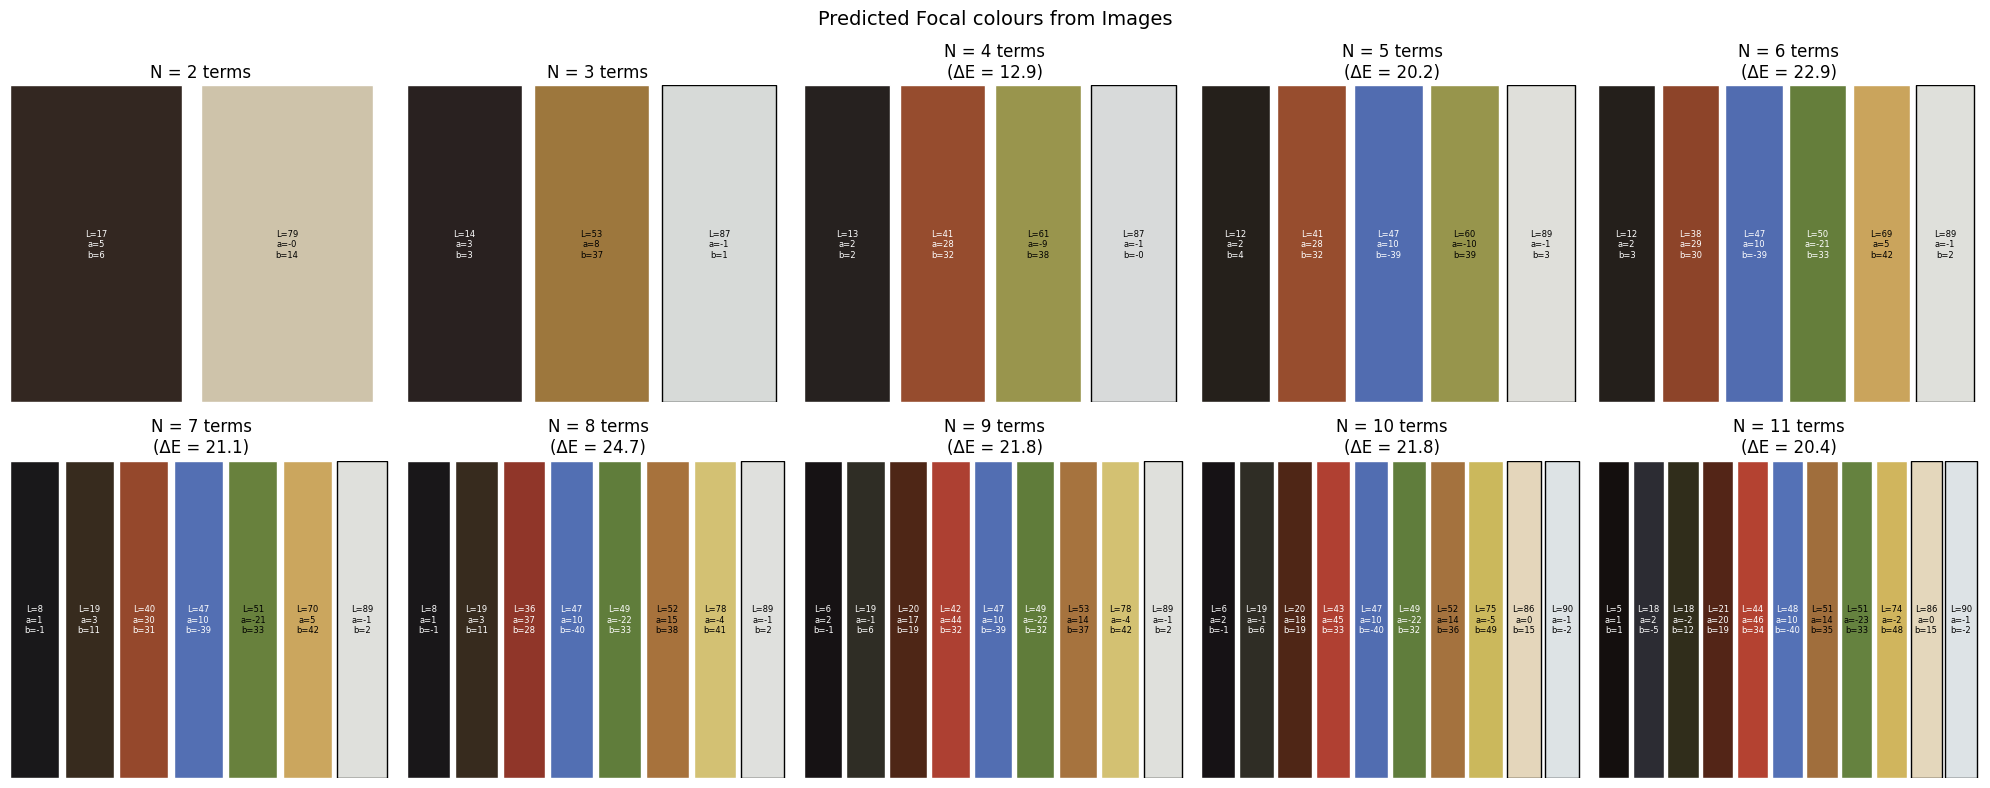

Saved: predicted_focal_colours.png


In [190]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for idx, n in enumerate(range(2, 12)):
    if n not in predicted_focals_kmeans or idx >= len(axes):
        continue

    ax = axes[idx]
    predicted = predicted_focals_kmeans[n]
    predicted_sorted = predicted[np.argsort(predicted[:, 0])]

    for i, lab in enumerate(predicted_sorted):
        rgb = lab_to_rgb_safe(lab)
        rect = patches.Rectangle((i, 0), 0.9, 1, facecolor=rgb,
                                 edgecolor='black' if lab[0] > 80 else 'white')
        ax.add_patch(rect)
        text_colour = 'white' if lab[0] < 50 else 'black'
        ax.text(i + 0.45, 0.5, f"L={lab[0]:.0f}\na={lab[1]:.0f}\nb={lab[2]:.0f}",
                ha='center', va='center', fontsize=6, color=text_colour)

    ax.set_xlim(0, n)
    ax.set_ylim(0, 1)

    delta_e = df_kmeans[df_kmeans.N == n]['Mean_DeltaE'].values
    title = f'N = {n} terms'
    if len(delta_e) > 0 and not np.isinf(delta_e[0]):
        title += f'\n(ΔE = {delta_e[0]:.1f})'
    ax.set_title(title)
    ax.axis('off')

plt.suptitle(f'Predicted Focal colours from Images', fontsize=14)
plt.tight_layout()
plt.savefig('predicted_focal_colours.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: predicted_focal_colours.png")

### Figure 2: Model vs Random Comparison

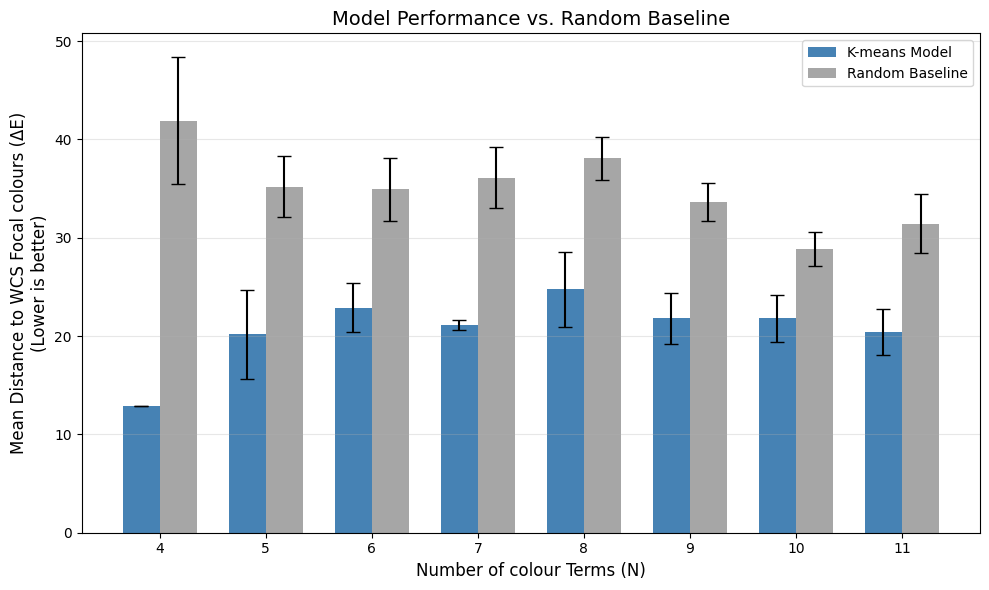

Saved: model_comparison.png


In [191]:
if len(df_kmeans) > 0 and len(df_random) > 0:
    fig, ax = plt.subplots(figsize=(10, 6))

    x = np.arange(len(df_kmeans))
    width = 0.35

    ax.bar(x - width/2, df_kmeans['Mean_DeltaE'], width,
           label='K-means Model', yerr=df_kmeans['Std'], capsize=5, color='steelblue')
    ax.bar(x + width/2, df_random['Mean_DeltaE'], width,
           label='Random Baseline', yerr=df_random['Std'], capsize=5, color='gray', alpha=0.7)

    ax.set_xlabel('Number of colour Terms (N)', fontsize=12)
    ax.set_ylabel('Mean Distance to WCS Focal colours (ΔE)\n(Lower is better)', fontsize=12)
    ax.set_title(
        f'Model Performance vs. Random Baseline', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(df_kmeans['N'].values)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Saved: model_comparison.png")

### Figure 3: Statistical Results

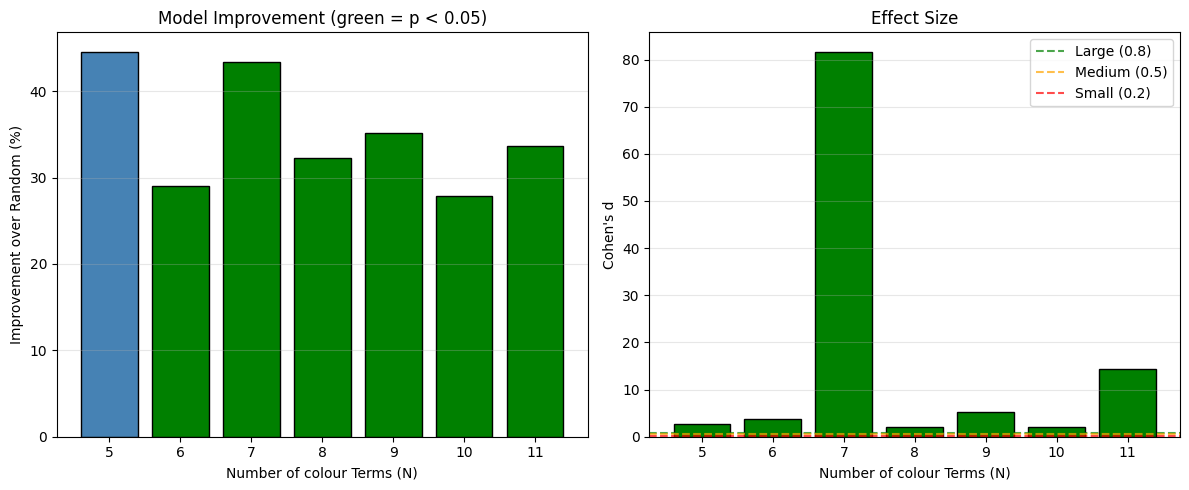

Saved: statistical_analysis.png


In [192]:
if len(df_stats) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    colours = ['green' if p < 0.05 else 'steelblue' for p in df_stats['p_value']]
    ax1.bar(df_stats['N'], df_stats['Improvement_%'],
            color=colours, edgecolor='black')
    ax1.axhline(y=0, color='black', linewidth=0.5)
    ax1.set_xlabel('Number of colour Terms (N)')
    ax1.set_ylabel('Improvement over Random (%)')
    ax1.set_title('Model Improvement (green = p < 0.05)')
    ax1.grid(axis='y', alpha=0.3)

    effect_colours = ['green' if d > 0.8 else 'orange' if d >
                     0.5 else 'red' for d in df_stats['Cohens_d']]
    ax2.bar(df_stats['N'], df_stats['Cohens_d'],
            color=effect_colours, edgecolor='black')
    ax2.axhline(y=0.8, color='green', linestyle='--',
                alpha=0.7, label='Large (0.8)')
    ax2.axhline(y=0.5, color='orange', linestyle='--',
                alpha=0.7, label='Medium (0.5)')
    ax2.axhline(y=0.2, color='red', linestyle='--',
                alpha=0.7, label='Small (0.2)')
    ax2.set_xlabel('Number of colour Terms (N)')
    ax2.set_ylabel("Cohen's d")
    ax2.set_title('Effect Size')
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.savefig('statistical_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Saved: statistical_analysis.png")

### Figure 4: colour Evolution Hierarchy

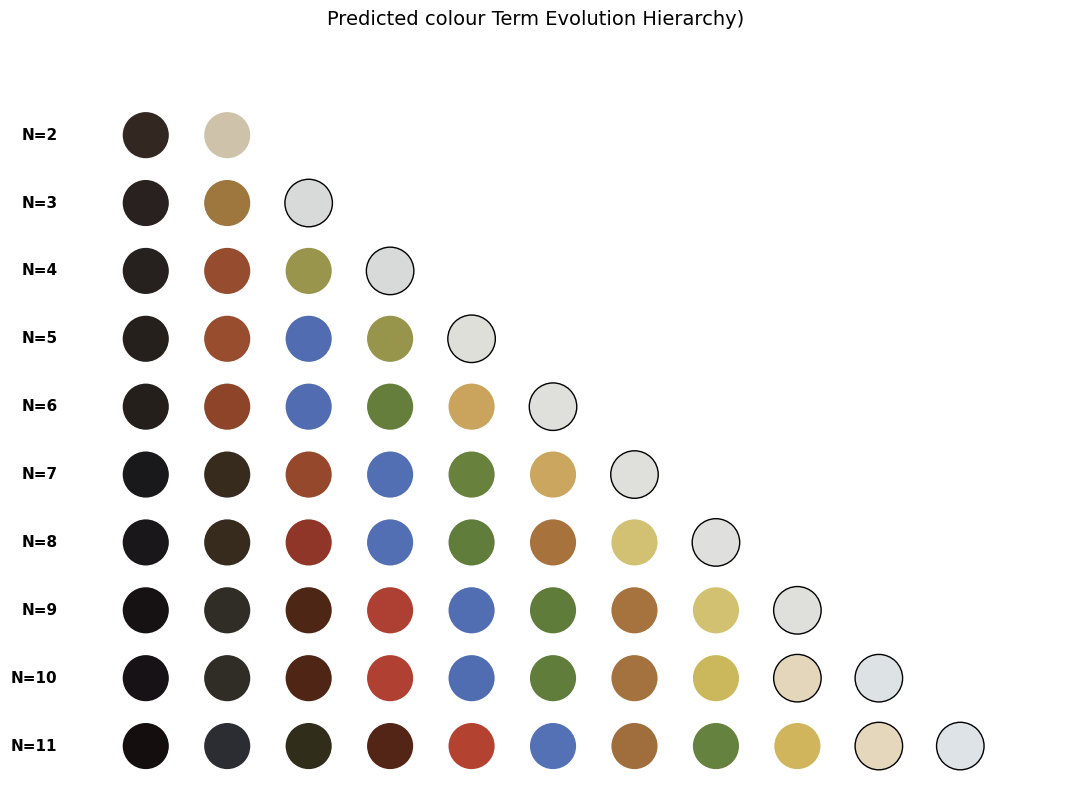

Saved: colour_evolution_hierarchy.png


In [193]:
fig, ax = plt.subplots(figsize=(14, 8))

for n in range(2, 12):
    if n not in predicted_focals_kmeans:
        continue

    predicted = predicted_focals_kmeans[n]
    predicted_sorted = predicted[np.argsort(predicted[:, 0])]
    y = 11 - n

    for i, lab in enumerate(predicted_sorted):
        rgb = lab_to_rgb_safe(lab)
        circle = plt.Circle((i * 1.2 + 0.5, y), 0.35, facecolor=rgb,
                            edgecolor='black' if lab[0] > 80 else 'white')
        ax.add_patch(circle)

    ax.text(-0.8, y, f'N={n}', ha='right', va='center',
            fontsize=11, fontweight='bold')

ax.set_xlim(-1.5, 14)
ax.set_ylim(-0.5, 10.5)
ax.set_aspect('equal')
ax.axis('off')
ax.set_title(
    f'Predicted colour Term Evolution Hierarchy)', fontsize=14)

plt.tight_layout()
plt.savefig('colour_evolution_hierarchy.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: colour_evolution_hierarchy.png")

### Figure 5: Silhouette and Intertia Plots

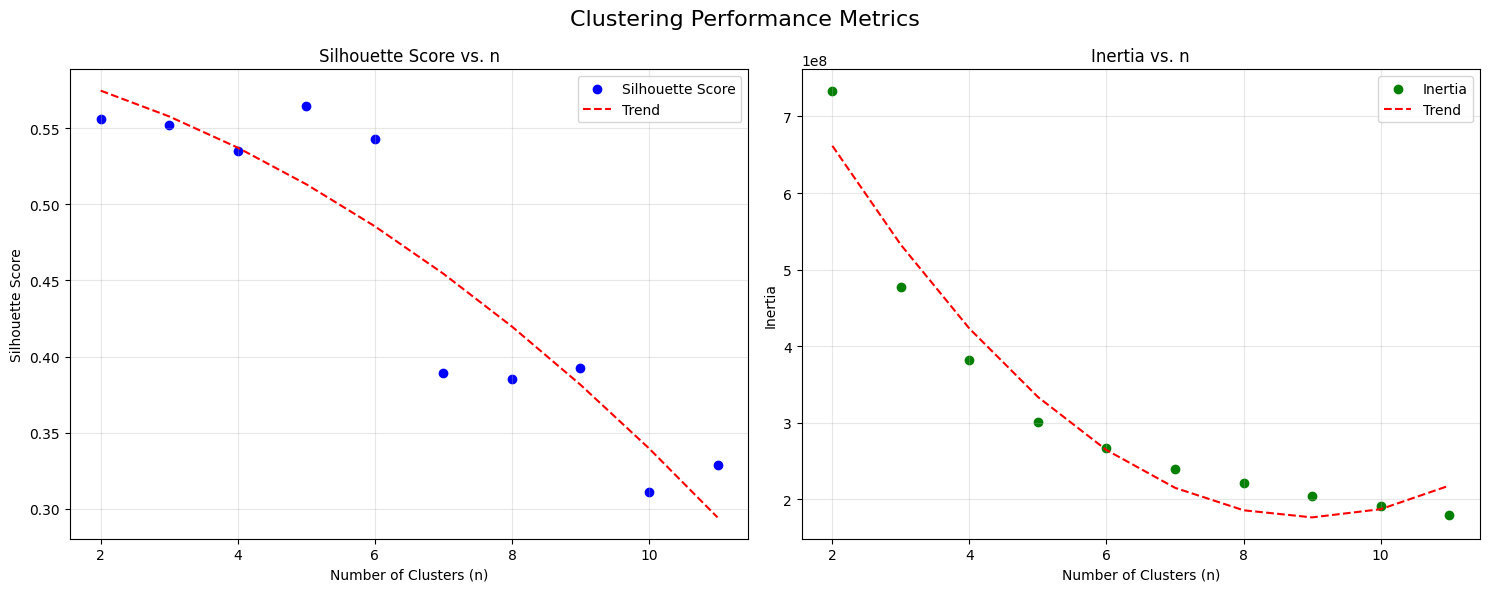

In [194]:
n_values = sorted(list(silhouette_inertia.keys()))
sil_values = [silhouette_inertia[n][0] for n in n_values]
inertia_values = [silhouette_inertia[n][1] for n in n_values]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Silhouette Score
ax1.scatter(n_values, sil_values, color='blue', label='Silhouette Score')
z1 = np.polyfit(n_values, sil_values, 2)
p1 = np.poly1d(z1)
ax1.plot(n_values, p1(n_values), "r--", label='Trend')

ax1.set_xlabel('Number of Clusters (n)')
ax1.set_ylabel('Silhouette Score')
ax1.set_title('Silhouette Score vs. n')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Inertia
ax2.scatter(n_values, inertia_values, color='green', label='Inertia')
z2 = np.polyfit(n_values, inertia_values, 2)
p2 = np.poly1d(z2)
ax2.plot(n_values, p2(n_values), "r--", label='Trend')

ax2.set_xlabel('Number of Clusters (n)')
ax2.set_ylabel('Inertia')
ax2.set_title('Inertia vs. n')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.suptitle('Clustering Performance Metrics', fontsize=16)
plt.tight_layout()

plt.savefig('silhouette_inertia_plots.png', dpi=300, bbox_inches='tight')
plt.show()

## Summary

In [195]:
if len(df_stats) > 0:
    mean_improvement = df_improvement['Improvement_%'].mean()
    sig_count = (df_stats['p_value'] < 0.05).sum()
    mean_d = df_stats['Cohens_d'].mean()

    print(f"\n1. Data source: images from Tiny ImageNet (n={len(image_files)} images)")
    print(f"2. Average improvement over random: {mean_improvement:.1f}%")
    print(
        f"3. Statistically significant (p<0.05): {sig_count}/{len(df_stats)}")
    print(f"4. Average Cohen's d: {mean_d:.2f}")

    if len([df_improvement['Improvement_%'] > 0]) > 0:
        best = df_improvement.loc[df_improvement['Improvement_%'].idxmax()]
        print(
            f"5. Best performance at N={int(best['N'])} ({best['Improvement_%']:.1f}% improvement)")

# Save results
df_kmeans.to_csv('results_kmeans.csv', index=False)
df_stats.to_csv('results_statistics.csv', index=False)


1. Data source: images from Tiny ImageNet (n=10000 images)
2. Average improvement over random: 39.7%
3. Statistically significant (p<0.05): 6/7
4. Average Cohen's d: 15.98
5. Best performance at N=4 (69.3% improvement)
